In [1]:
# Find out what features there are
# Find out what the correlations are 
# Find out how to decide which signal falls in which category
import pandas as pd
from pathlib import Path
import numpy as np
cwd = Path.cwd()
directory = cwd / "Project_Data_EE4C12_EPE_PQD/SNR_noiseless"

data = [pd.read_csv(f).drop(columns=['Unnamed: 0']) for f in directory.iterdir() if f.is_file()]

files = [f.name for f in directory.iterdir()]
print(files)

for a in data:
    print(a.shape)
    print("=====")

['Swell.csv', 'Transient.csv', 'Swell_harmonics.csv', 'Sag_harmonics.csv', 'Normal.csv', 'Sag.csv', 'Interruption.csv', 'Harmonics.csv', 'Flicker.csv']
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====
(149, 8)
=====


In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
corrMatrices = [np.corrcoef(cat,rowvar=False) for cat in data]

i = 0
# for e in corrMatrices:
#     sn.heatmap(e, annot=True)
#     plt.title(files[i])
#     plt.show()
#     i = i + 1

/home/robin/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/robin/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [3]:
import numpy as np
import pandas as pd

# Suppose you have something like this:
# corrMatrices = [np.corrcoef(cat, rowvar=False) for cat in data]
# and data[0].shape = (n_samples, n_features)
# Let's assume feature names are generic:
# feature_names = [f"Var{i}" for i in range(data[0].shape[1])]

colnames = data[0].columns

all_sorted_corrs = []

for i, corr_matrix in enumerate(corrMatrices):
    df = pd.DataFrame(corr_matrix, index=colnames, columns=colnames)

    # Take only upper triangle (to avoid duplicates and self-correlations)
    corr_pairs = (
        df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={'level_0': 'Var1', 'level_1': 'Var2', 0: 'Correlation'})
    )

    # Add absolute value and sort
    corr_pairs['AbsCorr'] = corr_pairs['Correlation'].abs()
    corr_pairs_sorted = (
        corr_pairs.sort_values('AbsCorr', ascending=False)
                  .drop(columns='AbsCorr')
                  .reset_index(drop=True)
    )

    all_sorted_corrs.append(corr_pairs_sorted)

# Now, all_sorted_corrs[i] is a sorted DataFrame for corrMatrices[i]


In [45]:
# Until what correlation level do we include the features of? I guess that's a performance tradeoff.

# def featureSnipper(data, sortedArray, listDepth):
#     topList = sortedArray.head(listDepth)
#     keepList = list(pd.unique(pd.concat([topList['Var1'], topList['Var2']])))
#     return data[keepList]

def featureSnipper(data, sortedArray, listLen):
    Len = 0
    listDepth = 1
    while Len < listLen:
        topList = sortedArray.head(listDepth)
        keepList = list(pd.unique(pd.concat([topList['Var1'], topList['Var2']])))
        Len = len(keepList)
        listDepth = listDepth + 1
        if(listDepth > 35):
            return data[keepList[:listLen]]
    print(keepList[:listLen])
    return data[keepList[:listLen]]

featureSnipper(data[0],all_sorted_corrs[0], 1)

['sd fma']


,sd fma
0,0.008624
1,0.003899
2,0.002648
3,0.009593
4,0.009100
...,...
144,0.003041
145,0.005824
146,0.005914
147,0.009330


In [ ]:
# Which classifier model should be used, is it the same for every PQD?
# What features should be included (aka, until what correlation level)

# TODO make function to easily test multiple models on different PQD at different correlation levels.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import svm
# Start with swell, splitting and scaling the data
Accuracy_LR = []
Recall_LR = []
bigData = pd.concat(data)

def dataGen(data, file, dataDepth):
    allData = pd.concat([data[file]] + data[:file] + data[file+1:])
    allData = featureSnipper(allData, all_sorted_corrs[file], dataDepth)
    
    y = [1]*149
    y.extend([0]*(8*149))
    
    return allData, y

def linearModel(dataX, dataY):
    scaler = StandardScaler()
    scaler.fit(dataX)
    
    X_scaled = scaler.transform(dataX)
    
    Shuffle_state = 4721
    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=Shuffle_state)
    # X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=Shuffle_state) # 0.25 x 0.8 = 0.2

    clf_lr = LogisticRegression().fit(X_train, y_train)
    y_prediction = clf_lr.predict(X_test)

    Accuracy_LR = accuracy_score(y_test, y_prediction)
    # F1_LR = f1_score(y_test, y_prediction)
    # Precision_LR = precision_score(y_test, y_prediction)
    Recall_LR = recall_score(y_test, y_prediction)
    # ConfusionMatrixDisplay(confusion_matrix(y_test, y_prediction)).plot()
    return Accuracy_LR, Recall_LR   

def SVM(dataX, dataY):
    scaler = StandardScaler()
    scaler.fit(dataX)
    
    X_scaled = scaler.transform(dataX)
    
    Shuffle_state = 4721
    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=Shuffle_state)
    X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=Shuffle_state) # 0.25 x 0.8 = 0.2

    clf_svmlin = svm.SVC(C=100.0, coef0=0.0, tol=1e-4, probability=True, kernel='linear').fit(X_train, y_train)
    y_prediction= clf_svmlin.predict(X_test)
    
    # clf_lr = LogisticRegression(max_iter = 10_000).fit(X_train, y_train)
    # y_prediction = clf_svmlin.predict(X_test)

    Accuracy_LR = accuracy_score(y_test, y_prediction)
    # F1_LR = f1_score(y_test, y_prediction)
    # Precision_LR = precision_score(y_test, y_prediction)
    Recall_LR = recall_score(y_test, y_prediction)
    # ConfusionMatrixDisplay(confusion_matrix(y_test, y_prediction)).plot()
    return Accuracy_LR, Recall_LR   



In [ ]:
for file in range(9): # Step through all csv's (all PQD's)
    Accuracy_LR = []
    Recall_LR = []
    for dataDepth in range(1,10): # Step through all the feature sets
        dataX, dataY = dataGen(data, file, dataDepth)
        Acc, Rec = linearModel(dataX, dataY)
        Accuracy_LR.append(Acc)
        Recall_LR.append(Rec)
        plt.show()
    print("======================")
    
    plt.title(str(files[file]))
    plt.plot(Accuracy_LR, label='Accuracy')
    plt.plot(Recall_LR , label='Recall')
    plt.legend()
    plt.ylim((0,1))
    plt.show()
        

['sd fma']
['sd fma', 'sd fma 3']
['sd fma', 'avg abs', 'sd fma 3']
['sd fma', 'avg abs', 'sd fma 3', 'sd']
['sd fma', 'avg abs', 'sd', 'sd fma 3', 'no. pks']
['sd fma', 'avg abs', 'sd', 'sd fma 3', 'no. pks', 'min']
['sd fma', 'avg abs', 'sd', 'min', 'no. pks', 'sd fma 3', 'max']
['sd fma', 'avg abs', 'sd', 'min', 'no. pks', 'max', 'sd fma 3', 'no. pt near 0']


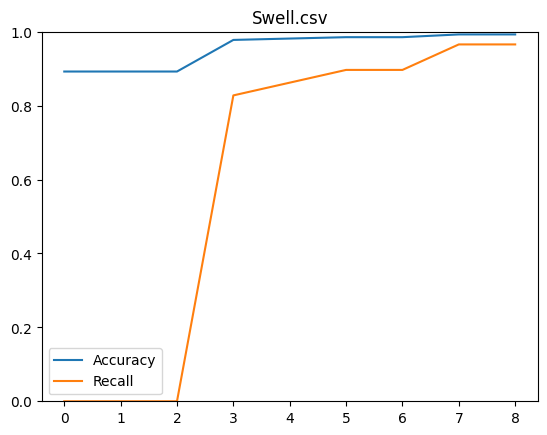

['no. pks']
['no. pks', 'sd fma 3']
['no. pks', 'avg abs', 'sd fma 3']
['no. pks', 'avg abs', 'sd fma 3', 'sd']
['no. pks', 'avg abs', 'sd', 'sd fma 3', 'min']
['no. pks', 'avg abs', 'sd', 'sd fma 3', 'min', 'max']
['no. pks', 'avg abs', 'sd', 'min', 'max', 'sd fma 3', 'sd fma']
['no. pks', 'avg abs', 'sd', 'min', 'max', 'sd fma', 'sd fma 3', 'no. pt near 0']


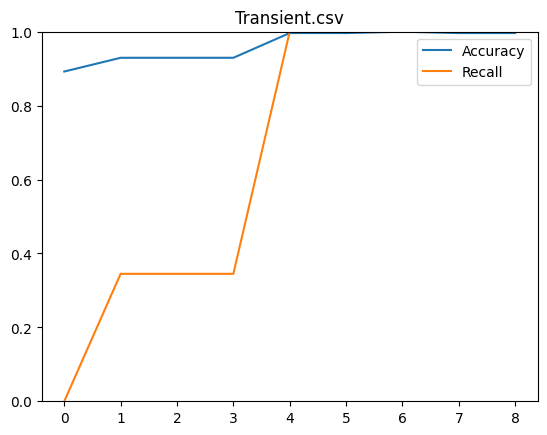

['avg abs']
['avg abs', 'sd']
['avg abs', 'no. pks', 'sd']
['avg abs', 'no. pks', 'sd', 'sd fma']
['avg abs', 'no. pks', 'sd', 'sd fma', 'min']
['avg abs', 'no. pks', 'sd', 'sd fma', 'min', 'sd fma 3']
['avg abs', 'no. pks', 'sd', 'max', 'sd fma', 'min', 'sd fma 3']
['avg abs', 'no. pks', 'sd', 'max', 'sd fma', 'min', 'sd fma 3', 'no. pt near 0']


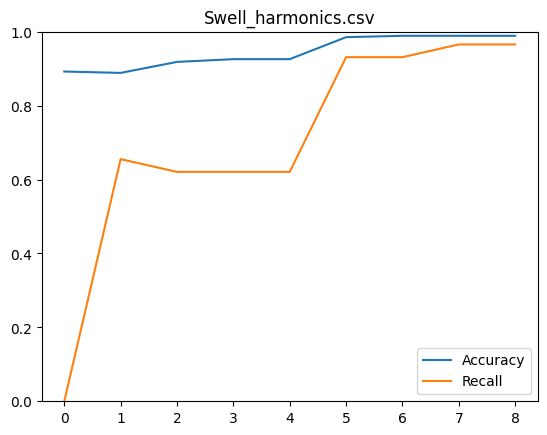

['avg abs']
['avg abs', 'max']
['avg abs', 'no. pks', 'max']
['avg abs', 'no. pks', 'max', 'sd fma']
['avg abs', 'no. pks', 'sd', 'max', 'sd fma']
['avg abs', 'no. pks', 'sd', 'max', 'sd fma', 'sd fma 3']
['avg abs', 'no. pks', 'sd', 'sd fma', 'max', 'sd fma 3', 'no. pt near 0']
['avg abs', 'no. pks', 'sd', 'sd fma', 'max', 'sd fma 3', 'no. pt near 0', 'min']


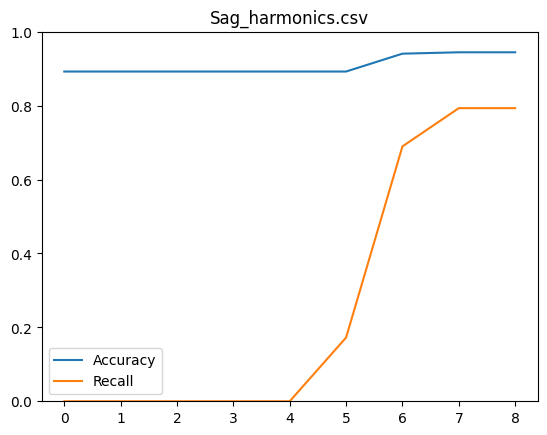

['sd fma']
['sd fma', 'sd fma 3']
['sd fma', 'no. pks', 'sd fma 3']
['sd fma', 'no. pks', 'min', 'sd fma 3']
['sd fma', 'no. pks', 'min', 'sd fma 3', 'no. pt near 0']
['sd fma', 'no. pks', 'min', 'avg abs', 'sd fma 3', 'no. pt near 0']


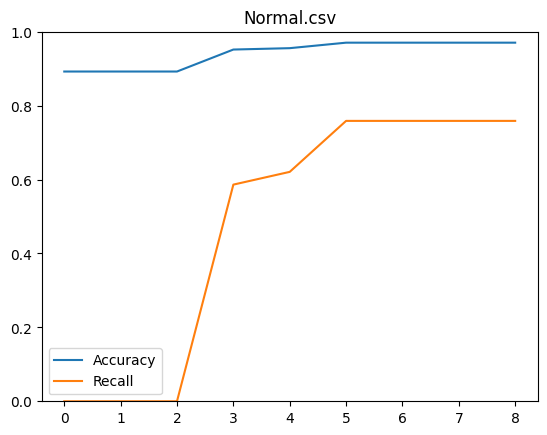

['sd fma']
['sd fma', 'sd fma 3']
['sd fma', 'avg abs', 'sd fma 3']
['sd fma', 'avg abs', 'sd fma 3', 'max']
['sd fma', 'avg abs', 'max', 'sd fma 3', 'no. pks']
['sd fma', 'avg abs', 'max', 'sd fma 3', 'no. pks', 'no. pt near 0']
['sd fma', 'avg abs', 'max', 'no. pks', 'sd fma 3', 'sd', 'no. pt near 0']
['sd fma', 'avg abs', 'max', 'no. pks', 'sd fma 3', 'sd', 'no. pt near 0', 'min']


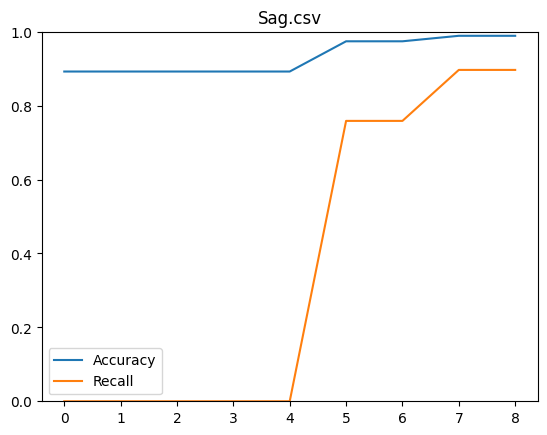

['sd fma']
['sd fma', 'sd fma 3']
['sd fma', 'no. pks', 'sd fma 3']
['sd fma', 'no. pks', 'avg abs', 'sd fma 3']
['sd fma', 'no. pks', 'avg abs', 'sd fma 3', 'sd']
['sd fma', 'no. pks', 'avg abs', 'sd fma 3', 'sd', 'max']
['sd fma', 'no. pks', 'avg abs', 'sd', 'sd fma 3', 'max', 'min']
['sd fma', 'no. pks', 'avg abs', 'sd', 'max', 'min', 'sd fma 3', 'no. pt near 0']


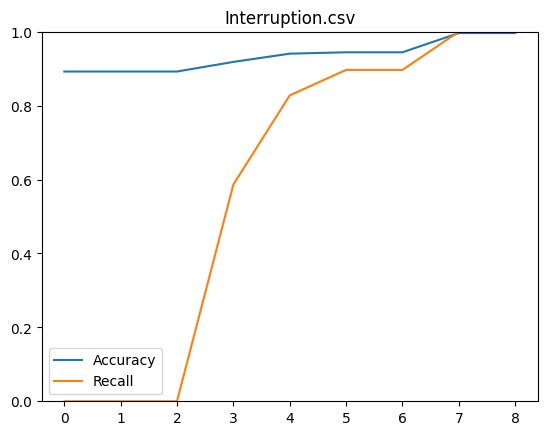

['no. pks']
['no. pks', 'sd fma']
['no. pks', 'sd fma', 'sd fma 3']
['no. pks', 'min', 'sd fma', 'sd fma 3']
['no. pks', 'min', 'sd fma', 'sd fma 3', 'no. pt near 0']
['no. pks', 'min', 'sd fma', 'avg abs', 'sd fma 3', 'no. pt near 0']


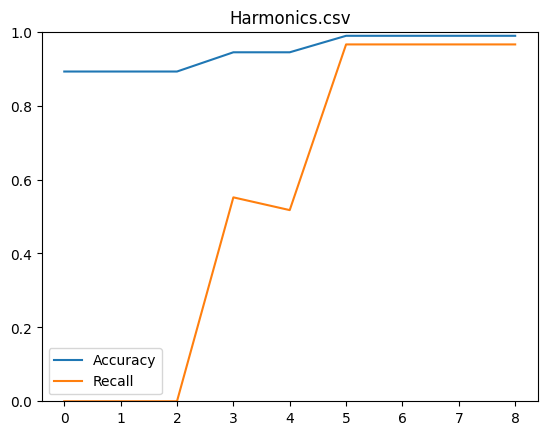

['sd fma']
['sd fma', 'sd fma 3']
['sd fma', 'avg abs', 'sd fma 3']
['sd fma', 'avg abs', 'sd fma 3', 'max']
['sd fma', 'avg abs', 'sd fma 3', 'max', 'sd']
['sd fma', 'avg abs', 'sd fma 3', 'max', 'sd', 'min']
['sd fma', 'avg abs', 'sd', 'max', 'no. pks', 'sd fma 3', 'min']
['sd fma', 'avg abs', 'sd', 'max', 'no. pks', 'min', 'sd fma 3', 'no. pt near 0']


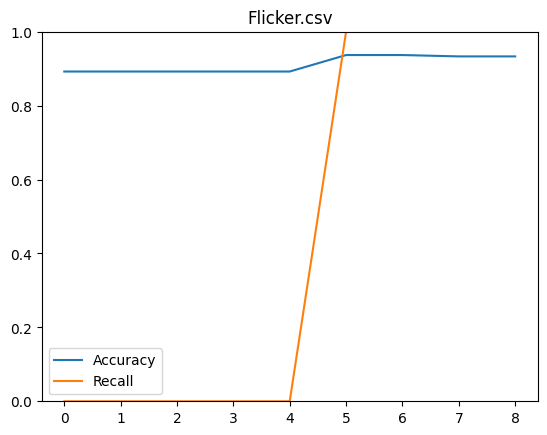

In [57]:
for file in range(9): # Step through all csv's (all PQD's)
    Accuracy_LR = []
    Recall_LR = []
    for dataDepth in range(1,10): # Step through all the feature sets
        dataX, dataY = dataGen(data, file, dataDepth)
        Acc, Rec = SVM(dataX, dataY)
        Accuracy_LR.append(Acc)
        Recall_LR.append(Rec)
        plt.show()
    print("======================")
    
    plt.title(str(files[file]))
    plt.plot(Accuracy_LR, label='Accuracy')
    plt.plot(Recall_LR , label='Recall')
    plt.legend()
    plt.ylim((0,1))
    plt.show()